In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

In [2]:
# Definir o ticker do Bitcoin
btc = yf.Ticker("BTC-USD")

# Obter dados históricos (desde 2014)
data = btc.history(start="2014-01-01", end=pd.to_datetime('today').strftime('%Y-%m-%d'))

# Visualizar as primeiras linhas
data.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0


In [3]:
# Resumo estatístico
data['Close'].describe()


count     3665.000000
mean     17958.809922
std      19757.089793
min        178.102997
25%       1169.280029
50%       9182.577148
75%      29283.103516
max      73083.500000
Name: Close, dtype: float64

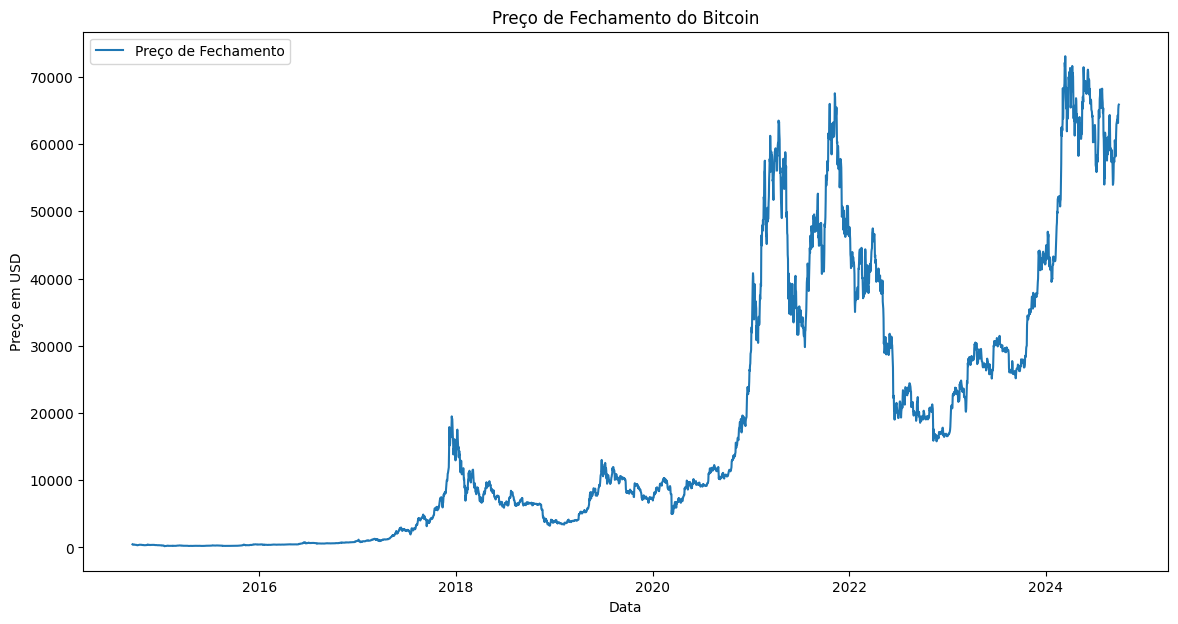

In [4]:
# Plotar o preço de fechamento
plt.figure(figsize=(14,7))
plt.plot(data.index, data['Close'], label='Preço de Fechamento')
plt.title('Preço de Fechamento do Bitcoin')
plt.xlabel('Data')
plt.ylabel('Preço em USD')
plt.legend()
plt.show()


## COMECO PREPARAÇÃO DADOS DO MODELO

## LSTM

2024-09-29 18:51:48.525659: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-29 18:51:48.526165: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-29 18:51:48.528341: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-29 18:51:48.534244: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-29 18:51:48.544479: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0359 - val_loss: 0.0182
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0013 - val_loss: 0.0250
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0055 - val_loss: 0.0021
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 8.6635e-04 - val_loss: 0.0026
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 7.8431e-04 - val_loss: 0.0024
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 10/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 4.4145e-04 - val_loss: 0.0021
Epoch 11/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.6762e-04 - val_loss: 0.0011
Epoch 12/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/

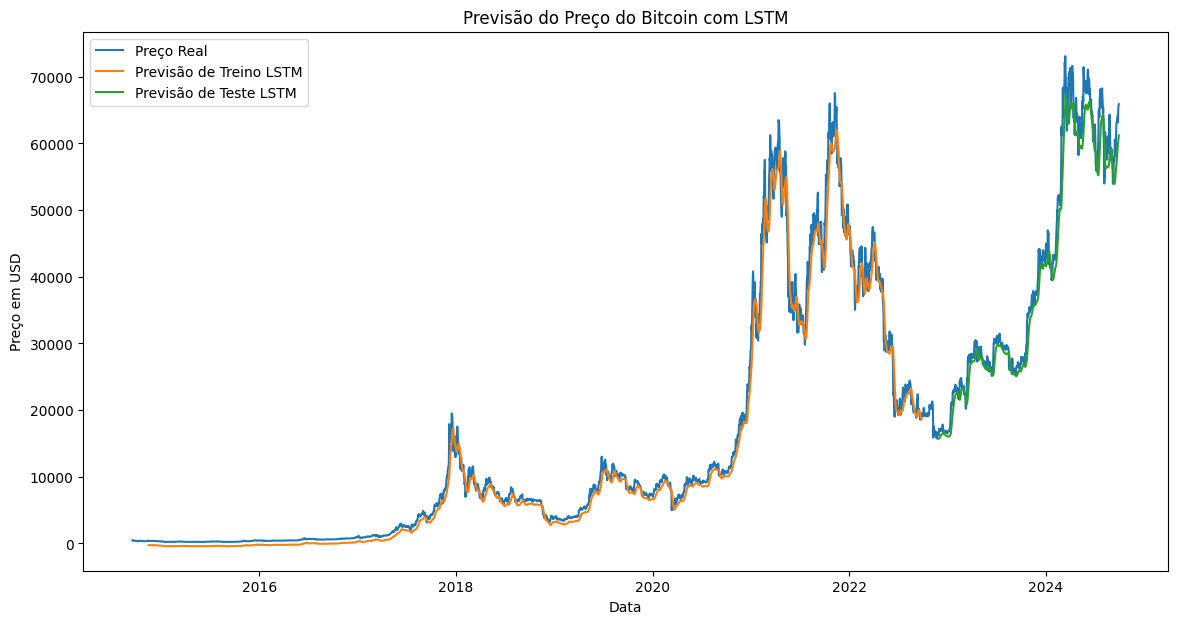

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import warnings
warnings.filterwarnings("ignore")

# Coleta dos dados do Bitcoin
btc = yf.Ticker("BTC-USD")
data_lstm = btc.history(start="2014-01-01", end=pd.to_datetime('today').strftime('%Y-%m-%d'))

# Seleção da coluna 'Close' e preparação dos dados
df_lstm = data_lstm[['Close']].reset_index()
dataset_lstm = df_lstm['Close'].values.reshape(-1, 1)

# Normalização dos dados
scaler_lstm = MinMaxScaler(feature_range=(0, 1))
scaled_data_lstm = scaler_lstm.fit_transform(dataset_lstm)

# Divisão em conjuntos de treino e teste usando train_test_split
train_data_lstm, test_data_lstm = train_test_split(scaled_data_lstm, test_size=0.2, shuffle=False)

# Parâmetro look_back
look_back = 60  # Número de passos de tempo anteriores usados para prever o próximo valor

# Usando TimeseriesGenerator para criar os conjuntos de dados para o LSTM
train_generator_lstm = TimeseriesGenerator(train_data_lstm, train_data_lstm, length=look_back, batch_size=64)
test_generator_lstm = TimeseriesGenerator(test_data_lstm, test_data_lstm, length=look_back, batch_size=64)

# Construção do modelo LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dense(1))

# Compilação do modelo
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

# Treinamento do modelo
model_lstm.fit(train_generator_lstm, epochs=20, validation_data=test_generator_lstm, verbose=1)

# Fazer previsões
train_predict_lstm = model_lstm.predict(train_generator_lstm)
test_predict_lstm = model_lstm.predict(test_generator_lstm)

# Obter os valores reais correspondentes
y_train_actual_lstm = train_data_lstm[look_back:]
y_test_actual_lstm = test_data_lstm[look_back:]

# Inverter a normalização
train_predict_lstm = scaler_lstm.inverse_transform(train_predict_lstm)
y_train_actual_lstm = scaler_lstm.inverse_transform(y_train_actual_lstm)

test_predict_lstm = scaler_lstm.inverse_transform(test_predict_lstm)
y_test_actual_lstm = scaler_lstm.inverse_transform(y_test_actual_lstm)

# Calcular RMSE
train_rmse_lstm = np.sqrt(mean_squared_error(y_train_actual_lstm, train_predict_lstm))
test_rmse_lstm = np.sqrt(mean_squared_error(y_test_actual_lstm, test_predict_lstm))

print(f'LSTM Train RMSE: {train_rmse_lstm}')
print(f'LSTM Test RMSE: {test_rmse_lstm}')

# Preparar as datas para plotagem
train_dates_lstm = df_lstm['Date'][look_back:len(train_predict_lstm)+look_back]
test_dates_lstm = df_lstm['Date'][len(train_data_lstm)+look_back:len(scaled_data_lstm)]

# Plotar previsões vs dados reais
plt.figure(figsize=(14, 7))
plt.plot(df_lstm['Date'], scaler_lstm.inverse_transform(scaled_data_lstm), label='Preço Real')
plt.plot(train_dates_lstm, train_predict_lstm, label='Previsão de Treino LSTM')
plt.plot(test_dates_lstm, test_predict_lstm, label='Previsão de Teste LSTM')
plt.title('Previsão do Preço do Bitcoin com LSTM')
plt.xlabel('Data')
plt.ylabel('Preço em USD')
plt.legend()
plt.show()

## GRU

Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0232 - val_loss: 0.0043
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0011 - val_loss: 8.6571e-04
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.4388e-04 - val_loss: 8.7810e-04
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.4857e-04 - val_loss: 5.9520e-04
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 3.1355e-04 - val_loss: 0.0011
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 2.3520e-04 - val_loss: 8.6709e-04
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 4.1365e-04 - val_loss: 5.0755e-04
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3.3903e-04 - val_loss: 5.4148e-04
Epoch 9/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 3.6316e-04 - val_loss: 4.5872e-04
Epoch 10/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.7711e-04 - val_loss: 4.4531e-04
Epoch 11/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.7793e-04 - val_loss: 9.

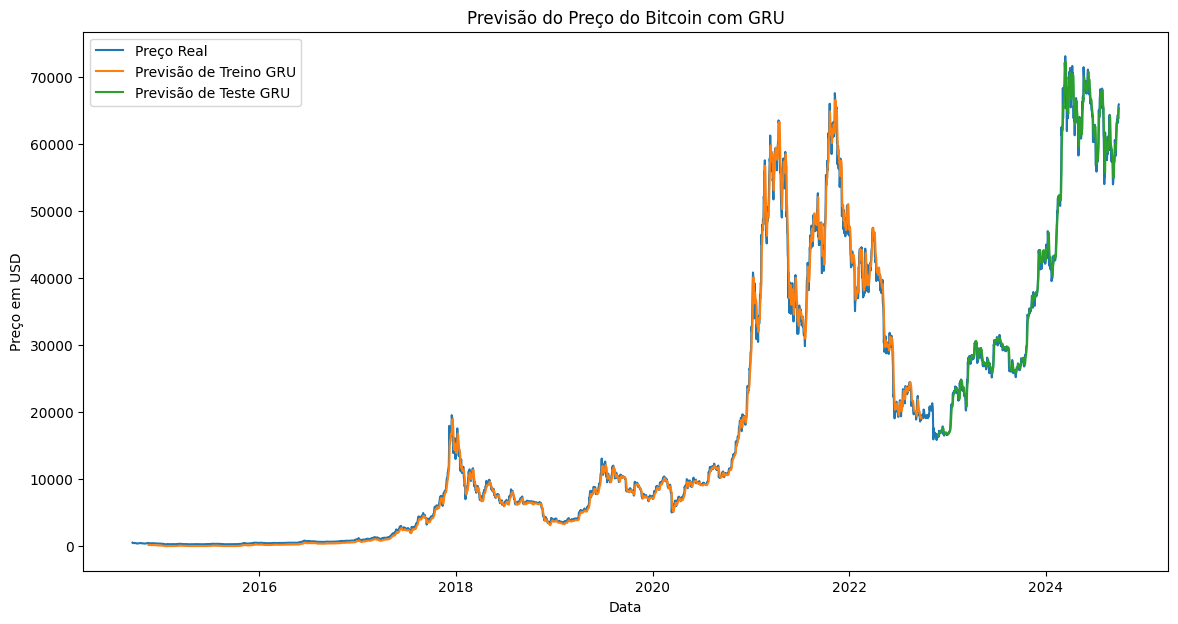

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import warnings
warnings.filterwarnings("ignore")

# Coleta dos dados do Bitcoin
btc = yf.Ticker("BTC-USD")
data_gru = btc.history(start="2014-01-01", end=pd.to_datetime('today').strftime('%Y-%m-%d'))

# Seleção da coluna 'Close' e preparação dos dados
df_gru = data_gru[['Close']].reset_index()
dataset_gru = df_gru['Close'].values.reshape(-1, 1)

# Normalização dos dados
scaler_gru = MinMaxScaler(feature_range=(0, 1))
scaled_data_gru = scaler_gru.fit_transform(dataset_gru)

# Divisão em conjuntos de treino e teste usando train_test_split
train_data_gru, test_data_gru = train_test_split(scaled_data_gru, test_size=0.2, shuffle=False)

# Parâmetro look_back
look_back = 60  # Número de passos de tempo anteriores usados para prever o próximo valor

# Usando TimeseriesGenerator para criar os conjuntos de dados para o GRU
train_generator_gru = TimeseriesGenerator(train_data_gru, train_data_gru, length=look_back, batch_size=64)
test_generator_gru = TimeseriesGenerator(test_data_gru, test_data_gru, length=look_back, batch_size=64)

# Construção do modelo GRU
model_gru = Sequential()
model_gru.add(GRU(units=50, return_sequences=True, input_shape=(look_back, 1)))
model_gru.add(GRU(units=50))
model_gru.add(Dense(1))

# Compilação do modelo
model_gru.compile(loss='mean_squared_error', optimizer='adam')

# Treinamento do modelo
model_gru.fit(train_generator_gru, epochs=20, validation_data=test_generator_gru, verbose=1)

# Fazer previsões
train_predict_gru = model_gru.predict(train_generator_gru)
test_predict_gru = model_gru.predict(test_generator_gru)

# Obter os valores reais correspondentes
y_train_actual_gru = train_data_gru[look_back:]
y_test_actual_gru = test_data_gru[look_back:]

# Inverter a normalização
train_predict_gru = scaler_gru.inverse_transform(train_predict_gru)
y_train_actual_gru = scaler_gru.inverse_transform(y_train_actual_gru)

test_predict_gru = scaler_gru.inverse_transform(test_predict_gru)
y_test_actual_gru = scaler_gru.inverse_transform(y_test_actual_gru)

# Calcular RMSE
train_rmse_gru = np.sqrt(mean_squared_error(y_train_actual_gru, train_predict_gru))
test_rmse_gru = np.sqrt(mean_squared_error(y_test_actual_gru, test_predict_gru))

print(f'GRU Train RMSE: {train_rmse_gru}')
print(f'GRU Test RMSE: {test_rmse_gru}')

# Preparar as datas para plotagem
train_dates_gru = df_gru['Date'][look_back:len(train_predict_gru)+look_back]
test_dates_gru = df_gru['Date'][len(train_data_gru)+look_back:len(scaled_data_gru)]

# Plotar previsões vs dados reais
plt.figure(figsize=(14, 7))
plt.plot(df_gru['Date'], scaler_gru.inverse_transform(scaled_data_gru), label='Preço Real')
plt.plot(train_dates_gru, train_predict_gru, label='Previsão de Treino GRU')
plt.plot(test_dates_gru, test_predict_gru, label='Previsão de Teste GRU')
plt.title('Previsão do Preço do Bitcoin com GRU')
plt.xlabel('Data')
plt.ylabel('Preço em USD')
plt.legend()
plt.show()

## COMPARAÇÃO GRU VS LSTM

In [7]:
# Importação das bibliotecas necessárias para métricas e visualização
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns

# Cálculo de métricas adicionais para o modelo LSTM
test_mae_lstm = mean_absolute_error(y_test_actual_lstm, test_predict_lstm)
test_r2_lstm = r2_score(y_test_actual_lstm, test_predict_lstm)

# Cálculo de métricas adicionais para o modelo GRU
test_mae_gru = mean_absolute_error(y_test_actual_gru, test_predict_gru)
test_r2_gru = r2_score(y_test_actual_gru, test_predict_gru)

# Criar um DataFrame com as métricas
results = pd.DataFrame({
    'Modelo': ['LSTM', 'GRU'],
    'RMSE': [test_rmse_lstm, test_rmse_gru],
    'MAE': [test_mae_lstm, test_mae_gru],
    'R²': [test_r2_lstm, test_r2_gru]
})

# Mostrar as métricas
print(results)




  Modelo         RMSE          MAE        R²
0   LSTM  2898.931377  2113.831007  0.972612
1    GRU  1334.913907   883.434688  0.994193


## Gráfico das métricas

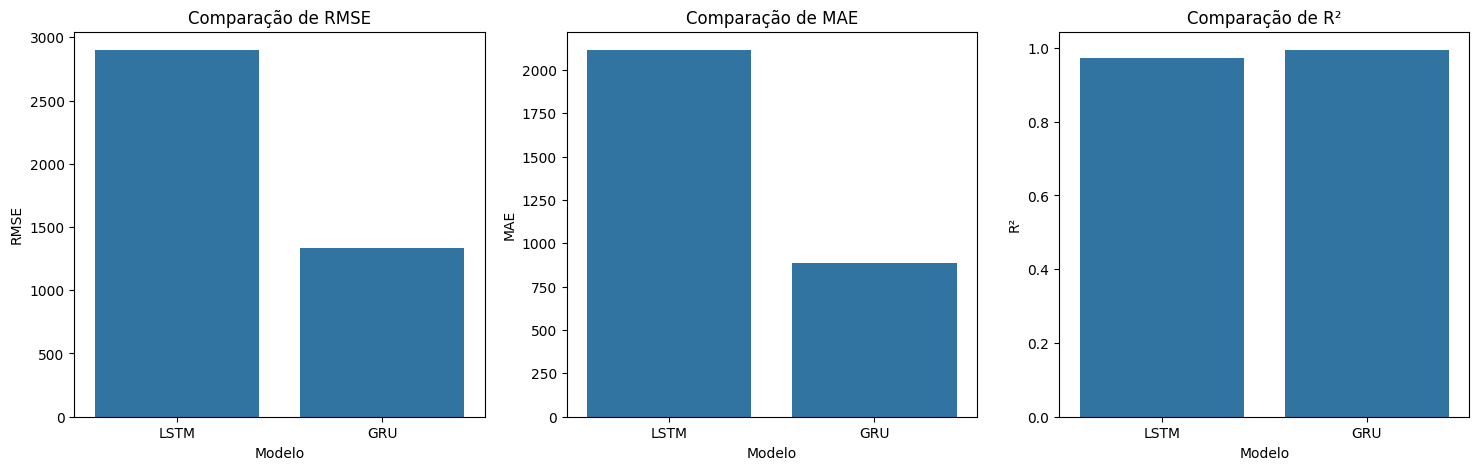

In [8]:
# Visualizar as métricas
fig, axes = plt.subplots(1, 3, figsize=(18,5))

sns.barplot(x='Modelo', y='RMSE', data=results, ax=axes[0])
axes[0].set_title('Comparação de RMSE')

sns.barplot(x='Modelo', y='MAE', data=results, ax=axes[1])
axes[1].set_title('Comparação de MAE')

sns.barplot(x='Modelo', y='R²', data=results, ax=axes[2])
axes[2].set_title('Comparação de R²')

plt.show()


## Comparação das previsões

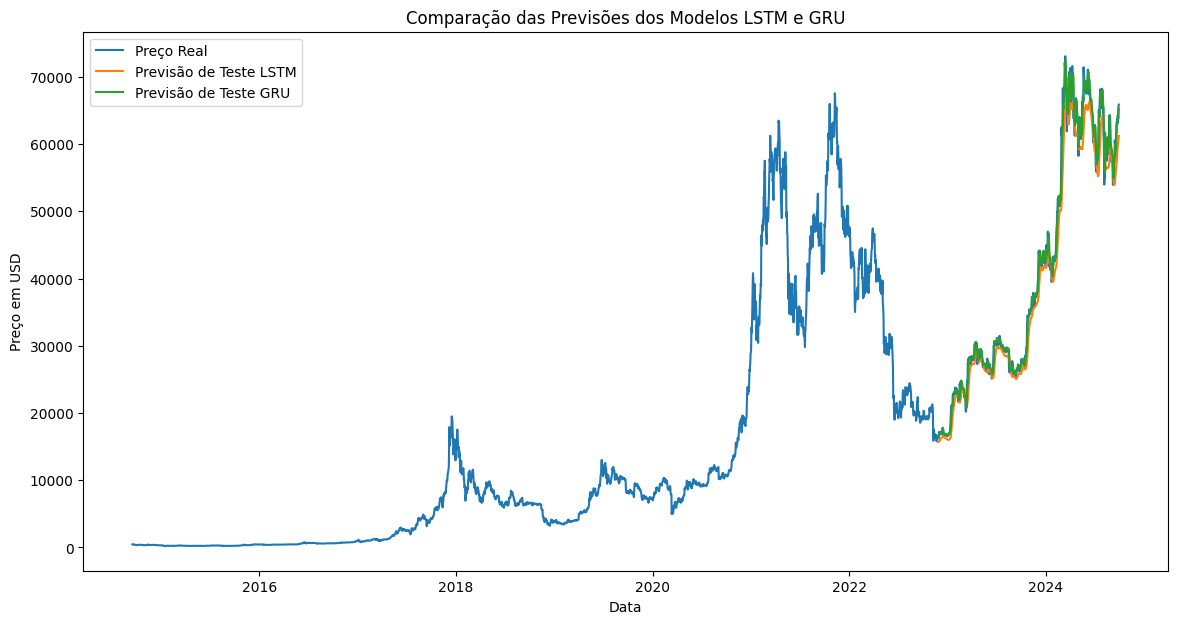

In [9]:
# Plotar previsões vs dados reais para ambos os modelos
plt.figure(figsize=(14, 7))
plt.plot(df_lstm['Date'], scaler_lstm.inverse_transform(scaled_data_lstm), label='Preço Real')
plt.plot(test_dates_lstm, test_predict_lstm, label='Previsão de Teste LSTM')
plt.plot(test_dates_gru, test_predict_gru, label='Previsão de Teste GRU')
plt.title('Comparação das Previsões dos Modelos LSTM e GRU')
plt.xlabel('Data')
plt.ylabel('Preço em USD')
plt.legend()
plt.show()


## ESCOLHA DE MODELO

Baseado nos índices comparados e na previsão, foi escolhido o modelo GRU ao invés do LSTM. Porém ainda é necessário rodar uma análise exploratória mais profunda nos dados (Será feito em bitcoin_exploring.py e depois tentar os modelos novamente pós essa análise.)